In [1]:
import json
from torch.utils.data import Dataset, DataLoader
from typing import Optional
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
from enum import Enum
import numpy as np
from typing import Callable, List, Any, Optional

def fingerprint(mol, nbits=1024) -> np.array:
    fp = AllChem.GetHashedMorganFingerprint(mol, 2, nBits=nbits)
    mol_rep = np.zeros((0,))
    DataStructs.ConvertToNumpyArray(fp, mol_rep)
    return mol_rep


MAX_MZ = 2000
def encode_spec(spec):
    vec = np.zeros(MAX_MZ * 2)
    for i in range(spec.shape[0]):
        mz_rnd = int(spec[i, 0])
        if mz_rnd >= MAX_MZ:
            continue
        logint= np.log10(spec[i, 1] + 1)
        if vec[mz_rnd] == 0 or vec[mz_rnd] < logint:
            vec[mz_rnd] = logint
            vec[MAX_MZ + mz_rnd] = np.log10((spec[i, 0] - mz_rnd) + 1)
    return vec

def gnps_parser(fname, from_mol: int = 0, to_mol: Optional[int] = None) -> List[Any]:
    molecules = []
    spectra = []
    with open(fname) as fl:
        for i, line in enumerate(fl.readlines()[from_mol:]):
            if to_mol is not None and from_mol + i >=  to_mol:
                break
            spec_str, smiles = line.strip().split('\t')
            spec = np.array(json.loads(spec_str))
            if len(spec) == 0 or len(spec.shape) != 2 or (spec <= 0).sum() > 0:
                continue
            # Round to 3 digits M/Z precision
            spec[:, 0] = np.round(spec[:, 0], 3)
            # We'll predict relative intensities
            #spec[:, 1] /= spec[:, 1].max()
            mol = Chem.MolFromSmiles(smiles)
            molecules.append(mol)
            spectra.append(encode_spec(spec))
            
    return molecules, spectra



class Mol2PropertiesDataset(Dataset):
    def __init__(
        self,
        fname: str,
        parser: Callable,
        mol_representation: Callable = fingerprint, 
        from_mol: int = 0,
        to_mol: Optional[int] = None,
        property_names: Optional[List[str]] = None,
        **mol_rep_kwargs,
    ):
        self.molecules, self.properties = parser(fname, from_mol=from_mol, to_mol=to_mol)
        self.property_names = property_names
        self.mol_representation = mol_representation
        self.mol_rep_kwargs = mol_rep_kwargs
        self.mol_reps = [self.mol_representation(mol, **mol_rep_kwargs) for mol in self.molecules]

    def __len__(self):
        return len(self.mol_reps)

    def __getitem__(self, idx: int):
        return self.mol_reps[idx], self.properties[idx]
    
ms2dataset = Mol2PropertiesDataset('data/pos_processed_gnps.txt', parser=gnps_parser, mol_representation=fingerprint, from_mol=0, to_mol=200)
ms2dataset[0]

(array([0., 3., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]))

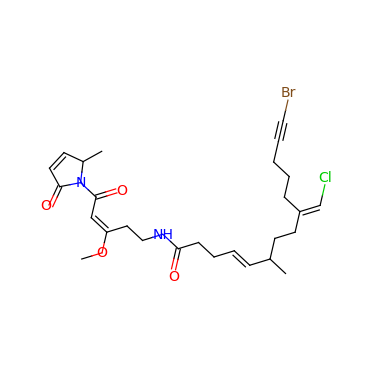

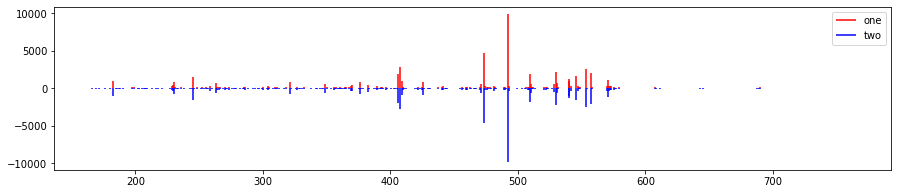

In [50]:
from matplotlib import pyplot as plt
def decode_spec(flatspec: np.array) -> np.array:
    intensities = flatspec[:len(flatspec) // 2]
    spln = sum(intensities > 0) 
    spec = np.zeros([spln, 2])
    
    spec[:, 1] = 10**(intensities[intensities > 0]) - 1
    spec[:, 0] = np.where(intensities > 0)[0] + (10**(flatspec[len(flatspec) // 2:][intensities > 0]) - 1)
    return spec
                            
def plot_specs(flatspec1, flatspec2, labels=['one', 'two'], mol=None):
    if mol is not None:
        f = Chem.Draw.MolToMPL(mol, size=(200,200))
        plt.axis('off')
    f, axarr = plt.subplots(nrows=1,  ncols=1,figsize=(15, 3))
    s1, s2 = decode_spec(flatspec1), decode_spec(flatspec2)
    axarr.vlines(s1[:, 0], ymin=0, ymax=s1[:, 1], color='red', label=labels[0])
    axarr.vlines(s2[:, 0], ymin=-s2[:, 1], ymax=0, color='blue', label=labels[1])
    axarr.legend()
    
    
idx = 12
plot_specs(ms2dataset[idx][1], ms2dataset[idx][1], mol=ms2dataset.molecules[idx])

In [3]:
import torch

if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu" 
device = torch.device(dev)
print(device)

cuda:0


In [4]:
molecule_dim = 4096
prop_dim = MAX_MZ * 2

to_idx = 15000
train_data= Mol2PropertiesDataset('data/pos_processed_gnps.txt', parser=gnps_parser, mol_representation=fingerprint, from_mol=0, to_mol=to_idx, nbits=molecule_dim)
test_data = Mol2PropertiesDataset('data/pos_processed_gnps.txt', parser=gnps_parser, mol_representation=fingerprint, from_mol=to_idx, to_mol=to_idx + 100, nbits=molecule_dim)
len(train_data)

RDKit WARNING: [10:26:04] WARNING: not removing hydrogen atom without neighbors
[10:26:04] WARNING: not removing hydrogen atom without neighbors


14530

100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [31:00<00:00,  4.65s/it]


Text(0, 0.5, 'Loss')

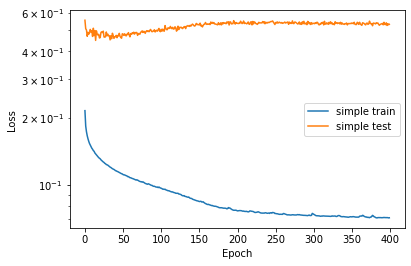

In [5]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from matplotlib import pyplot as plt
from tqdm import tqdm

torch.cuda.empty_cache() 

class ResBlock(torch.nn.Module):
    def __init__(self, module):
        super().__init__()
        self.module = module

    def forward(self, inputs):
        return self.module(inputs) + inputs

class Mol2SpecSimple(nn.Module):
    def __init__(self, molecule_dim: int, prop_dim: int):
        super().__init__()
        self.molecule_dim = molecule_dim
        self.prop_dim = prop_dim
        
        hdim = 2000
        
        nl = nn.SiLU()
        self.mlp_layers = nn.Sequential(
            ResBlock(
                nn.Sequential(
                    nn.Linear(molecule_dim, hdim),
                    nl,
                    nn.Linear(hdim, hdim),
                    nl,
                    nn.Linear(hdim, molecule_dim),
                )
            ),
            ResBlock(
                nn.Sequential(
                    nn.Linear(molecule_dim, hdim),
                    nl,
                    nn.Linear(hdim, hdim),
                    nl,
                    nn.Linear(hdim, molecule_dim),
                )
            ),
            ResBlock(
                nn.Sequential(
                    nn.Linear(molecule_dim, hdim),
                    nl,
                    nn.Linear(hdim, hdim),
                    nl,
                    nn.Linear(hdim, molecule_dim),
                )
            ),
            nn.Linear(molecule_dim, prop_dim),
        )


    def forward(self, mol_vec):
        mol_vec = mol_vec.type(torch.FloatTensor)
        #mol_vec = (mol_vec - mol_vec.mean(0))/(mol_vec.std(0) + 1)
        mz_res = self.mlp_layers(mol_vec.to(device))
        return mz_res
    
def train_evaluate(net, train_loader, test_loader, n_epochs, **opt_params):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), **opt_params)

    losses = {'train': {}, 'test': {}}
    for epoch in tqdm(range(n_epochs)):
        losses['train'][epoch] = 0
        losses['test'][epoch] = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            loss = criterion(net(inputs), targets.float().to(device))
            loss.backward()
            optimizer.step()

            losses['train'][epoch] += loss.item() / len(train_loader)
        
        for inputs, targets in test_loader:
            with torch.no_grad():
                loss = criterion(net(inputs), targets.to(device))
                losses['test'][epoch] += loss.item() / len(test_loader)
                
                if epoch % 50 == 0:
                    pass
                    #plt.figure()
                    #plt.title(f'Loss {loss}, intensities')
                    #pred = net(inputs).data
                    #plt.scatter(10**targets[0][mz_dim:], 10**pred[0][mz_dim:])
                    #plt.figure()
                    #plt.title('MZs')
                    #plt.scatter(10**targets[0][:mz_dim], 10**pred[0][:mz_dim])
                    #plot_specs(
                    #    targets[0].data, pred[0].data
                    #)

                
    return losses


train_loader = DataLoader(train_data, batch_size=200, shuffle=True)
test_loader = DataLoader(test_data, batch_size=100, shuffle=True)

curves = {}
model = Mol2SpecSimple(molecule_dim=molecule_dim, prop_dim=prop_dim)
model.to(device)
curves['simple'] = train_evaluate(model, train_loader, test_loader, n_epochs=400, lr=3e-4)#, momentum=0.9)


plt.figure()
for ltype, losses in curves.items():
    for name, loss in losses.items():
        plt.plot(list(loss.values()), label=f'{ltype} {name}')
        plt.yscale('log')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

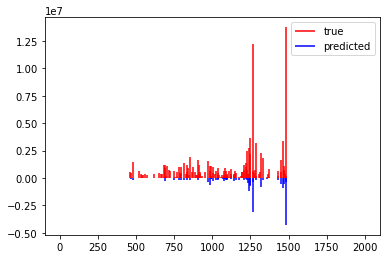

<Figure size 432x288 with 0 Axes>

In [15]:
with torch.no_grad():
    idx = 100
    x = train_data[idx][0]
    y = train_data[idx][1]
    pred = model(torch.Tensor(x[np.newaxis, :])).data[0]
    plot_specs(
        y, pred.cpu().numpy(),
        labels=['true', 'predicted'],
    )
    plt.figure()
    #plt.scatter(10**y[:mz_dim] - 1, 10**pred[:mz_dim] - 1)


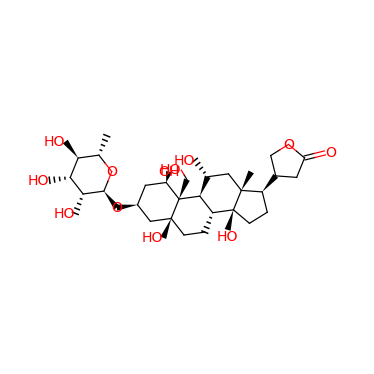

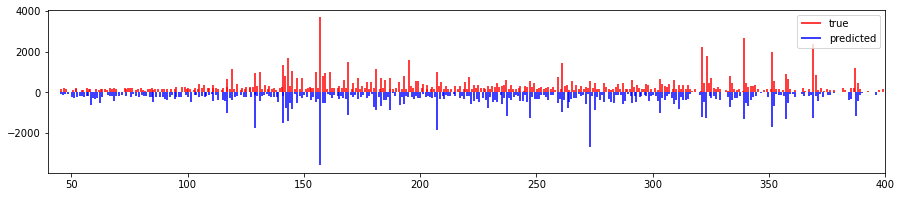

In [65]:
with torch.no_grad():
    idx = 21
    x = test_data[idx][0]
    y = test_data[idx][1]
    pred = model(torch.Tensor(x[np.newaxis, :])).data[0]
    plot_specs(
        y, pred.cpu().numpy(),
        labels=['true', 'predicted'],
        mol=test_data.molecules[idx]
    )
    plt.legend()
    #plt.figure()
    #plt.scatter(10**y[:mz_dim] - 1, 10**pred[:mz_dim] - 1)
    plt.xlim(40, 400)

In [14]:
import numpy as np
a = np.array([[1,2], [2, 1], [3, 0]])


a[a[:,1].argsort(), :]

array([[3, 0],
       [2, 1],
       [1, 2]])

In [5]:
l = [[1,2] for x in range(2)]
l[0].append(2)
l

[[1, 2, 2], [1, 2]]